# Refined Stratified Sampling Example 3

- Author: Mohit S. Chauhan 
- Date: Jan 25, 2019

In this example, Stratified sampling is used to generate samples from Uniform distribution and sample expnsion is done adaptively using Refined Stratified Sampling.

Import the necessary libraries. Here we import standard libraries such as numpy, matplotlib and other necessary library for plots, but also need to import the STS, RSS and Krig class from UQpy.


In [1]:
from UQpy.SampleMethods import STS
from UQpy.SampleMethods import RSS
from UQpy.Surrogates import Kriging
from UQpy.RunModel import RunModel
from UQpy.Distributions import Uniform
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.patches as patches
import numpy as np

Create a distribution object.

In [2]:
marginals = [Uniform(loc=0., scale=1.), Uniform(loc=0., scale=1.)]

Run stratified sampling.

In [3]:
x = STS(dist_object=marginals, sts_design=[4, 4], random_state=1)
initial_samples=x.samples.copy()

This plot shows the samples and stratas generated by the STS class.

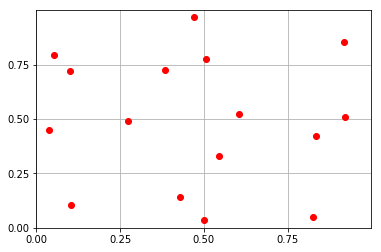

In [4]:
fig = plt.figure()
plt.plot(x.samples[:, 0], x.samples[:, 1], 'ro')
ax = fig.gca()
ax.set_xticks(np.arange(0, 1, 0.25))
ax.set_yticks(np.arange(0, 1, 0.25))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.show()

RunModel class is used to estimate the function value at sample points generated using STS class.

In [5]:
rmodel = RunModel(model_script='python_model_function.py', vec='False')

This figure shows the actual function defined in python model script.

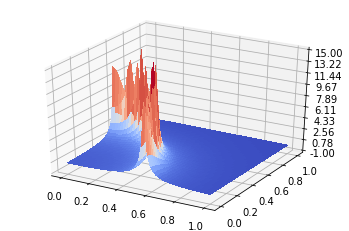

In [6]:
rmodel1 = RunModel(model_script='python_model_function.py', vec='False')
rmodel1.run(samples=x.samples)
num = 50
x1 = np.linspace(0, 1, num)
x2 = np.linspace(0, 1, num)
x1v, x2v = np.meshgrid(x1, x2)
y_act = np.zeros([num, num])
r1model = RunModel(model_script='python_model_function.py')
for i in range(num):
    for j in range(num):
        r1model.run(samples=np.array([[x1v[i, j], x2v[i, j]]]), append_samples=False)
        y_act[i, j] = r1model.qoi_list[0]
        
fig1 = plt.figure()
ax1 = fig1.gca(projection='3d')
# Plot for estimated values
surf = ax1.plot_surface(x1v, x2v, y_act, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Customize the z axis.
ax1.set_zlim(-1, 15)
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Krig class generated a surrogate model using STS samples and function value at those points.

In [7]:
K = Kriging(reg_model='Linear', corr_model='Exponential', nopt=20, corr_model_params=[1, 1])
K.fit(samples=x.samples, values=rmodel1.qoi_list)
print(K.corr_model_params)

[4.38122272 0.05817027]


This figure shows the surrogate model generated using Krig class from initial samples.

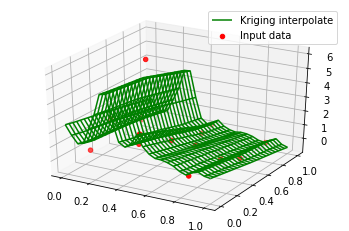

In [8]:
num = 25
x1 = np.linspace(0, 1, num)
x2 = np.linspace(0, 1, num)
x1v, x2v = np.meshgrid(x1, x2)
y = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j] = K.predict(np.array([x1v[i, j], x2v[i, j]]))

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
# Plot for estimated values
kr = ax2.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = ax2.scatter3D(x.samples[:, 0], x.samples[:, 1], rmodel1.qoi_list, color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()

A RSS class object is initiated by using the STS, RunModel and Krig object.

In [9]:
z = RSS(sample_object=x, runmodel_object=rmodel, krig_object=K, random_state=2)

After initiating the RSS class object, new samples are generated using the RSS.sample method.

In [10]:
z.run(nsamples=200)

This figure shows the final samples generated using RSS class, where red dots shows the initial samples.

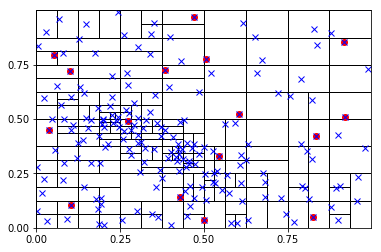

In [11]:
fig3 = plt.figure()
ax3 = fig3.gca()
ax3.set_xticks(np.arange(0, 1, 0.25))
ax3.set_yticks(np.arange(0, 1, 0.25))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(initial_samples[:, 0], initial_samples[:, 1], 'ro')
plt.plot(z.sample_object.samplesU01[:, 0], z.sample_object.samplesU01[:, 1], 'bx')
for i in range(z.nsamples):
    rect = patches.Rectangle(z.sample_object.strata.origins[i], z.sample_object.strata.widths[i, 0], z.sample_object.strata.widths[i, 1], linewidth=1,
                             edgecolor='black', facecolor='none')
    ax3.add_patch(rect)
plt.show()

Krig class is used to generate a surrogate model using final samples from RSS class.

In [12]:
K2 = Kriging(reg_model='Linear', corr_model='Exponential', corr_model_params=z.krig_object.corr_model_params, dimension=2)
K2.fit(samples=z.sample_object.samples, values=z.runmodel_object.qoi_list)

This figure shows the final surrogate model, generated using 200 samples.

<Figure size 432x288 with 0 Axes>

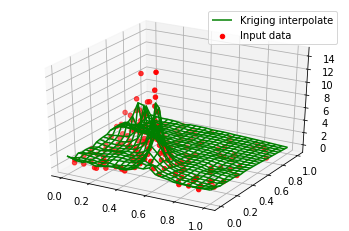

In [13]:
y = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j] = K2.predict(np.array([x1v[i, j], x2v[i, j]]))

plt.clf()
fig4 = plt.figure()
a4 = fig4.gca(projection='3d')
# Plot for estimated values
kr = a4.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = a4.scatter3D(z.sample_object.samples[:, 0], z.sample_object.samples[:, 1], z.runmodel_object.qoi_list, color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()